In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [5]:
def total_least_squares(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)

    U = np.vstack((x - x_mean, y - y_mean)).T
    
    UT_U = np.dot(U.T, U)

    eigenvalues, eigenvectors = np.linalg.eig(UT_U)
    
    min_idx = np.argmin(eigenvalues)
    a, b = eigenvectors[:, min_idx]
    
    d = a * x_mean + b * y_mean
    
    if d < 0:
        a, b, d = -a, -b, -d
        
    return a, b, d

In [6]:
print("--- Part (a): TLS on Line 1 ---")
try:
    D = np.genfromtxt("lines.csv", delimiter=",", skip_header=1)
    
    x1 = D[:, 0]
    y1 = D[:, 3]
    
    a1, b1, d1 = total_least_squares(x1, y1)
    print(f"Parameters for Line 1:")
    print(f"a = {a1:.4f}, b = {b1:.4f}, d = {d1:.4f}")
    print(f"Equation: {a1:.4f}x + {b1:.4f}y = {d1:.4f}\n")

except OSError:
    print("Error: 'lines.csv' not found. Please ensure it is in the same directory.")
    np.random.seed(42)
    D = np.random.rand(100, 6) * 10 - 5

--- Part (a): TLS on Line 1 ---
Parameters for Line 1:
a = 0.7736, b = -0.6337, d = 3.7942
Equation: 0.7736x + -0.6337y = 3.7942



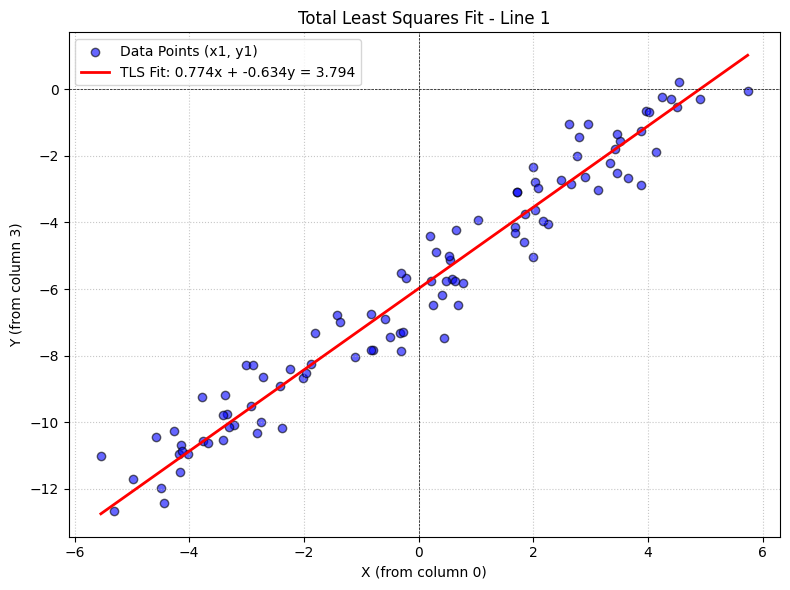

In [9]:
plt.figure(figsize=(8, 6))

plt.scatter(x1, y1, color='blue', alpha=0.6, edgecolors='k', label='Data Points (x1, y1)')

x_min, x_max = np.min(x1), np.max(x1)
x_vals = np.array([x_min, x_max])

if abs(b1) > 1e-6:
    y_vals = (d1 - a1 * x_vals) / b1
    plt.plot(x_vals, y_vals, color='red', linewidth=2, 
             label=f'TLS Fit: {a1:.3f}x + {b1:.3f}y = {d1:.3f}')
else:
    x_val = d1 / a1
    plt.axvline(x=x_val, color='red', linewidth=2, 
                label=f'TLS Vertical Fit: x = {x_val:.3f}')

plt.title('Total Least Squares Fit - Line 1')
plt.xlabel('X (from column 0)')
plt.ylabel('Y (from column 3)')

plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')

plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()

plt.show()

In [7]:
print("--- Part (b): RANSAC for 3 lines ---")

X_cols = D[:, :3]
Y_cols = D[:, 3:]
X_all = X_cols.flatten()
Y_all = Y_cols.flatten()

points = np.vstack((X_all, Y_all)).T

def run_ransac(points, iterations=1000, distance_threshold=0.1):
    best_inliers_idx = []
    best_model = None
    
    for _ in range(iterations):
        idx = np.random.choice(len(points), 2, replace=False)
        sample = points[idx]
        
        a, b, d = total_least_squares(sample[:, 0], sample[:, 1])
        
        distances = np.abs(a * points[:, 0] + b * points[:, 1] - d)
        
        inliers = np.where(distances < distance_threshold)[0]
 
        if len(inliers) > len(best_inliers_idx):
            best_inliers_idx = inliers
            best_model = (a, b, d)
            
    final_a, final_b, final_d = total_least_squares(
        points[best_inliers_idx, 0], 
        points[best_inliers_idx, 1]
    )
    
    return (final_a, final_b, final_d), best_inliers_idx

found_lines = []
remaining_points = points.copy()

threshold = 0.5 

for i in range(3):
    if len(remaining_points) < 2:
        break 
        
    model, inliers_idx = run_ransac(remaining_points, iterations=500, distance_threshold=threshold)
    
    a, b, d = model
    found_lines.append(model)
    print(f"Found Line {i+1}: {a:.4f}x + {b:.4f}y = {d:.4f} (Inliers: {len(inliers_idx)})")
    
    remaining_points = np.delete(remaining_points, inliers_idx, axis=0)

print(f"Points left as outliers: {len(remaining_points)}")

--- Part (b): RANSAC for 3 lines ---
Found Line 1: 0.4679x + 0.8838y = 1.9281 (Inliers: 83)
Found Line 2: -0.7191x + 0.6949y = 0.7287 (Inliers: 67)
Found Line 3: 0.7876x + -0.6162y = 3.7515 (Inliers: 63)
Points left as outliers: 87


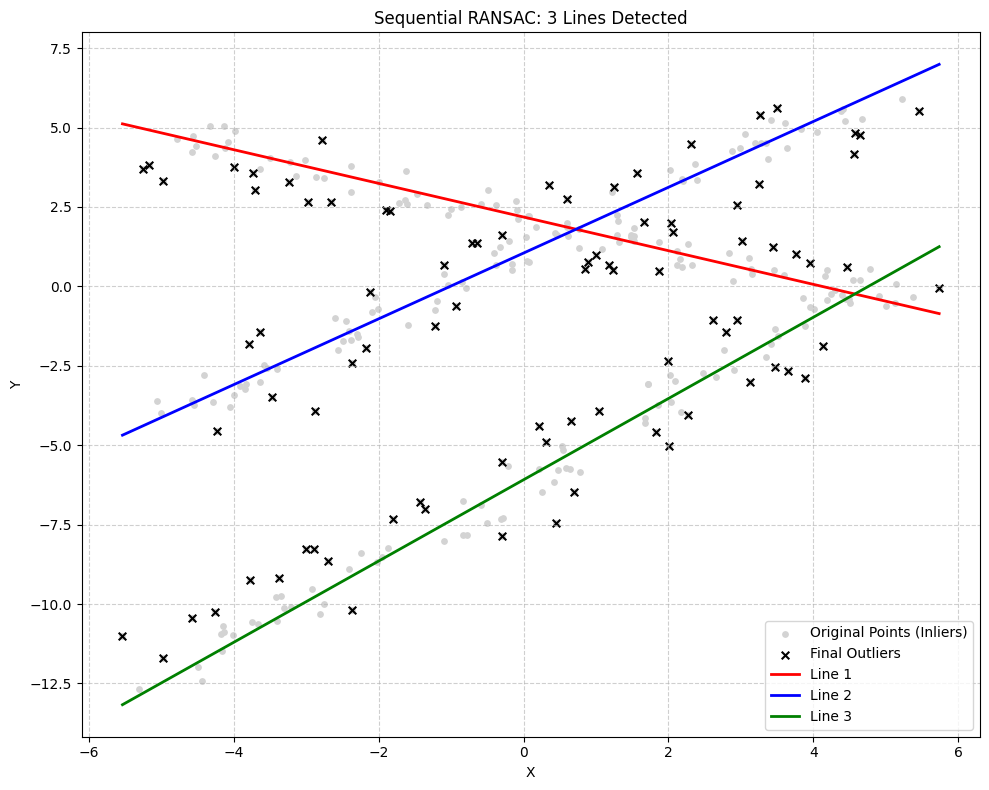

In [ ]:
plt.figure(figsize=(10, 8))

plt.scatter(points[:, 0], points[:, 1], color='lightgray', s=15, label='Original Points (Inliers)')

if len(remaining_points) > 0:
    plt.scatter(remaining_points[:, 0], remaining_points[:, 1], 
                color='black', marker='x', s=30, label='Final Outliers')

x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
x_vals = np.array([x_min, x_max])

colors = ['red', 'blue', 'green']

for i, (a, b, d) in enumerate(found_lines):
    color = colors[i % len(colors)]
    
    if abs(b) > 1e-6:
        y_vals = (d - a * x_vals) / b
        plt.plot(x_vals, y_vals, color=color, linewidth=2, label=f'Line {i+1}')
    else:
        x_val = d / a
        plt.axvline(x=x_val, color=color, linewidth=2, label=f'Line {i+1}')

plt.title('Sequential RANSAC: 3 Lines Detected')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

In [ ]:
def measure_earrings(image_path):
    focal_length_mm = 8.0
    distance_mm = 720.0
    pixel_size_mm = 2.2 * 1e-3 

    mm_per_pixel = pixel_size_mm * (distance_mm / focal_length_mm)
    print(f"Camera Scale: 1 pixel = {mm_per_pixel:.3f} mm\n")

    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not load image.")
        return
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]

    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        
        width_mm = w * mm_per_pixel
        height_mm = h * mm_per_pixel
        
        print(f"Earring {i+1}:")
        print(f"  Pixel dimensions: {w}px width x {h}px height")
        print(f"  Physical size:    {width_mm:.2f}mm width x {height_mm:.2f}mm height")
        
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

    cv2.imshow('Measured Earrings', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

measure_earrings('earrings.jpg')

Camera Scale: 1 pixel = 0.198 mm

Earring 1:
  Pixel dimensions: 382px width x 400px height
  Physical size:    75.64mm width x 79.20mm height
Earring 2:
  Pixel dimensions: 382px width x 400px height
  Physical size:    75.64mm width x 79.20mm height


Click 4 corners on the turf in this exact order:
1. Top-Left  2. Top-Right  3. Bottom-Right  4. Bottom-Left
Point 1: (686, 159)
Point 2: (841, 160)
Point 3: (1331, 670)
Point 4: (112, 664)

Four points selected. Press any key to continue to the transformation...


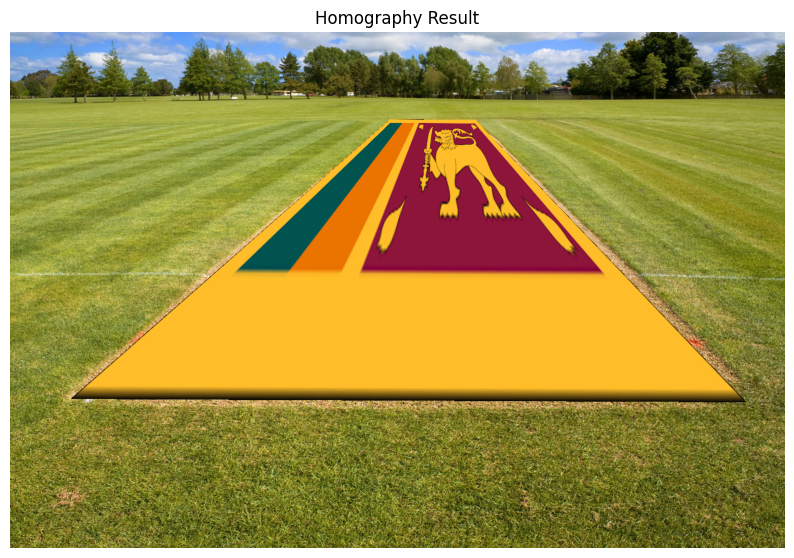

: 

In [ ]:
points = []
img_display = None

def mouse_callback(event, x, y, flags, param):
    global points, img_display
    if event == cv2.EVENT_LBUTTONDOWN:
        if len(points) < 4:
            points.append((x, y))
            print(f"Point {len(points)}: ({x}, {y})")
            cv2.circle(img_display, (x, y), 5, (0, 0, 255), -1)
            cv2.imshow("Select 4 Points", img_display)
            
        if len(points) == 4:
            print("\nFour points selected. Press any key to continue to the transformation...")

def main():
    global img_display, points

    turf_img = cv2.imread("turf.jpg")
    flag_img = cv2.imread("flag.png") 
    
    if turf_img is None or flag_img is None:
        raise FileNotFoundError("Could not find turf.jpg or flag.jpg. Check your file paths.")

    img_display = turf_img.copy()
    cv2.namedWindow("Select 4 Points")
    cv2.setMouseCallback("Select 4 Points", mouse_callback)
    
    print("Click 4 corners on the turf in this exact order:")
    print("1. Top-Left  2. Top-Right  3. Bottom-Right  4. Bottom-Left")
    
    cv2.imshow("Select 4 Points", img_display)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    if len(points) != 4:
        print("You didn't select 4 points. Exiting.")
        return

    pts_dst = np.array(points, dtype=np.float32)

    h, w = flag_img.shape[:2]
    pts_src = np.array([
        [0, 0],       
        [w, 0],       
        [w, h],       
        [0, h]        
    ], dtype=np.float32)

    matrix, status = cv2.findHomography(pts_src, pts_dst, cv2.RANSAC)

    turf_h, turf_w = turf_img.shape[:2]
    warped_flag = cv2.warpPerspective(flag_img, matrix, (turf_w, turf_h))

    gray_warped = cv2.cvtColor(warped_flag, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray_warped, 1, 255, cv2.THRESH_BINARY)

    mask_inv = cv2.bitwise_not(mask)
    
    turf_bg = cv2.bitwise_and(turf_img, turf_img, mask=mask_inv)
    
    final_result = cv2.add(turf_bg, warped_flag)
    final_result_rgb = cv2.cvtColor(final_result, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 8))
    plt.imshow(final_result_rgb)
    plt.title("Homography Result")
    plt.axis('off') 
    plt.show()

if __name__ == "__main__":
    main()

